# Neural Net Modeling
In continuing with modeling, I want to see if I can better my scores and skipped song finds using Neural Networks. I will use the Keras library with the pre-processing tokenizer. This is still a work in progress that I need to do more studying on.



#### Table of Contents
<br>`Pre-Processing`</br>

- [Baseline](#base)
- [Tokenizer](#token)
- [Weights](#weights)

<br>`Modeling`</br>

- [GridSearch Keras](#gs)
- [Input NN](#input)
- [Visualisation](#viz)

<br>`Conclusion`</br>

- [Notebook Conclusion](#conc)    

### Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text # to add more stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall, AUC, Accuracy
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, RMSprop, Adam
from keras.constraints import maxnorm

In [2]:
df = pd.read_csv('./data/lyrics_cleaned.csv')

### Baseline<a id='base'></a>  
Continuing with using confusion matrix and f1 score to have close in-depth look at how the neural network is scoring with my imbalanced data.

In [3]:
neg, pos = np.bincount(df['skip'])
total = neg + pos
print(f"Total: {total}\n    Skipped(1) count is: {pos} ({100 * pos / total:.2f}% of total)\n   Not Skipped(0) count is: {neg} ({100 * neg / total:.2f}% of total)\n")

Total: 11455
    Skipped(1) count is: 2750 (24.01% of total)
   Not Skipped(0) count is: 8705 (75.99% of total)



Again changing some words to a more vague term

In [4]:
some_words = open("./data/drop_words.txt").read().split()

for i in some_words:   
    df['lyrics'] = df['lyrics'].str.lower().str.replace(rf"\b{i}\b", 'vulgar')

### Train Test Split
Tokenizer to create a Bag of Words, then train, test, split followed by standard scaler

In [5]:
X = df['lyrics']
y = df['skip']

### Tokenizer<a id='token'></a>

In [6]:
token = Tokenizer()
token.fit_on_texts(X)
encode_X = token.texts_to_matrix(X, mode='count')

In [7]:
# since the categories are unbalanced I will stratify y
X_train, X_test, y_train, y_test = train_test_split(encode_X, y, random_state=42, stratify=y) 
# Check shapes of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8591, 58899), (2864, 58899), (8591,), (2864,))

In [8]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Re-Weighting<a id='weights'></a>  
Because my classes as so imbalanced (76%, 24%) I want to re-weigh my classes, so that the smaller class has a heavier weight 

In [9]:

weight_for_0 = (1 / neg)*(total)/2.0  # /2 helps keep the loss to similar size
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1} # mapping the weights

print(f'Weight for class 0: {weight_for_0 :.2f}')
print(f'Weight for class 1: {weight_for_1 :.2f}')

Weight for class 0: 0.66
Weight for class 1: 2.08


Again due to the imbalance factor, looking at accuracy alone is not a good metric, so getting better insight with recall, precision, AUC and confusion matrix will tell me how well my model is doing

In [10]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      Accuracy(name='accuracy')]


### Gridsearching  Keras Classifier<a id='gs'></a>  

In [11]:
def create_model(dropout_rate=0.0, weight_constraint=0): # creating a model function
    model = Sequential() # instantiate model
    model.add(Dense(15, # first layer
                    input_dim=X_train_sc.shape[1], # shape of X_train_sc
                    kernel_initializer='normal', # starting weight
                    activation='linear',
                    kernel_constraint=maxnorm(4)))
    model.add(Dropout(0.0)) #dropout (regularization)
    model.add(Dense(1, # exit layer
                    kernel_initializer='normal', # final weight
                    activation='sigmoid'))
    optimizer = RMSprop(lr= 0.01, momentum= 0.6)
    model.compile(loss='binary_crossentropy',optimizer=optimizer,  metrics=METRICS) 
    # metrics is defined is previous cell, optimizer is initialized at adam and kernel_initializer at uniform, the gridsearch
    # will overwrite these as it searches for best params.
    return model

In [12]:
# using keras wrappers we can 'trick' it into allowing us to gridsearch a Keras Classifier
model = KerasClassifier(build_fn=create_model, verbose=1)
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [13]:
# grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)

# feeding into gridsearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [ ]:
grid_result = grid.fit(X_train_sc, y_train, epochs=100, verbose=0, validation_data=(X_test_sc, y_test), class_weight=class_weight, batch_size=100) 
# because my biggest issue is that validation loss keeps increasing, I wanted to make sure I add validation data for score output.
# class is being re-weighted for hopefully better scores

#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # returns best score and best params

### Input Model<a id='input'></a>  

In [14]:
model = Sequential()
model.add(Dense(units = 15, 
                input_dim=X_train_sc.shape[1],
                kernel_initializer= 'normal',
                activation='linear',
                kernel_constraint=maxnorm(4)))

model.add(Dropout(0.0))

model.add(Dense(1, 
                kernel_initializer= 'normal',
                activation='sigmoid'))

In [15]:
optimizer = RMSprop(lr = 0.01, momentum = 0.6)

In [16]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics=METRICS)

In [17]:
history = model.fit(X_train_sc, y_train, epochs=100, verbose=1, validation_data=(X_test_sc, y_test), class_weight=class_weight, batch_size=100)


Epoch 1/100
86/86 [==============================] - 3s 30ms/step - loss: 0.5967 - tp: 1408.0000 - fp: 1529.0000 - tn: 5000.0000 - fn: 654.0000 - precision: 0.4794 - recall: 0.6828 - auc: 0.7817 - accuracy: 4.6560e-04 - val_loss: 0.5655 - val_tp: 446.0000 - val_fp: 405.0000 - val_tn: 1771.0000 - val_fn: 242.0000 - val_precision: 0.5241 - val_recall: 0.6483 - val_auc: 0.7967 - val_accuracy: 0.0010
Epoch 2/100
86/86 [==============================] - 2s 18ms/step - loss: 0.5810 - tp: 1395.0000 - fp: 1375.0000 - tn: 5154.0000 - fn: 667.0000 - precision: 0.5036 - recall: 0.6765 - auc: 0.7943 - accuracy: 0.0021 - val_loss: 0.5891 - val_tp: 277.0000 - val_fp: 290.0000 - val_tn: 1886.0000 - val_fn: 411.0000 - val_precision: 0.4885 - val_recall: 0.4026 - val_auc: 0.6819 - val_accuracy: 0.0000e+00
Epoch 3/100
86/86 [==============================] - 2s 18ms/step - loss: 0.5777 - tp: 1416.0000 - fp: 1335.0000 - tn: 5194.0000 - fn: 646.0000 - precision: 0.5147 - recall: 0.6867 - auc: 0.7972 - acc

86/86 [==============================] - 2s 18ms/step - loss: 0.5673 - tp: 1394.0000 - fp: 1353.0000 - tn: 5176.0000 - fn: 668.0000 - precision: 0.5075 - recall: 0.6760 - auc: 0.7957 - accuracy: 8.1481e-04 - val_loss: 0.6655 - val_tp: 452.0000 - val_fp: 420.0000 - val_tn: 1756.0000 - val_fn: 236.0000 - val_precision: 0.5183 - val_recall: 0.6570 - val_auc: 0.7820 - val_accuracy: 0.0017
Epoch 22/100
86/86 [==============================] - 2s 18ms/step - loss: 0.5573 - tp: 1428.0000 - fp: 1343.0000 - tn: 5186.0000 - fn: 634.0000 - precision: 0.5153 - recall: 0.6925 - auc: 0.8082 - accuracy: 0.0014 - val_loss: 0.6700 - val_tp: 413.0000 - val_fp: 428.0000 - val_tn: 1748.0000 - val_fn: 275.0000 - val_precision: 0.4911 - val_recall: 0.6003 - val_auc: 0.7421 - val_accuracy: 6.9832e-04
Epoch 23/100
86/86 [==============================] - 2s 18ms/step - loss: 0.5756 - tp: 1420.0000 - fp: 1382.0000 - tn: 5147.0000 - fn: 642.0000 - precision: 0.5068 - recall: 0.6887 - auc: 0.7974 - accuracy: 9.3

86/86 [==============================] - 2s 18ms/step - loss: 0.5764 - tp: 1416.0000 - fp: 1423.0000 - tn: 5106.0000 - fn: 646.0000 - precision: 0.4988 - recall: 0.6867 - auc: 0.7954 - accuracy: 9.3121e-04 - val_loss: 0.5563 - val_tp: 425.0000 - val_fp: 396.0000 - val_tn: 1780.0000 - val_fn: 263.0000 - val_precision: 0.5177 - val_recall: 0.6177 - val_auc: 0.7822 - val_accuracy: 0.0000e+00
Epoch 42/100
86/86 [==============================] - 2s 18ms/step - loss: 0.5738 - tp: 1373.0000 - fp: 1316.0000 - tn: 5213.0000 - fn: 689.0000 - precision: 0.5106 - recall: 0.6659 - auc: 0.7909 - accuracy: 0.0010 - val_loss: 0.5737 - val_tp: 445.0000 - val_fp: 429.0000 - val_tn: 1747.0000 - val_fn: 243.0000 - val_precision: 0.5092 - val_recall: 0.6468 - val_auc: 0.7846 - val_accuracy: 0.0000e+00
Epoch 43/100
86/86 [==============================] - 2s 18ms/step - loss: 0.5755 - tp: 1438.0000 - fp: 1409.0000 - tn: 5120.0000 - fn: 624.0000 - precision: 0.5051 - recall: 0.6974 - auc: 0.7967 - accuracy:

86/86 [==============================] - 2s 18ms/step - loss: 0.5791 - tp: 1421.0000 - fp: 1358.0000 - tn: 5171.0000 - fn: 641.0000 - precision: 0.5113 - recall: 0.6891 - auc: 0.7960 - accuracy: 0.0010 - val_loss: 0.6506 - val_tp: 446.0000 - val_fp: 596.0000 - val_tn: 1580.0000 - val_fn: 242.0000 - val_precision: 0.4280 - val_recall: 0.6483 - val_auc: 0.7310 - val_accuracy: 0.0000e+00
Epoch 62/100
86/86 [==============================] - 2s 18ms/step - loss: 0.5646 - tp: 1444.0000 - fp: 1439.0000 - tn: 5090.0000 - fn: 618.0000 - precision: 0.5009 - recall: 0.7003 - auc: 0.8049 - accuracy: 0.0016 - val_loss: 0.7319 - val_tp: 474.0000 - val_fp: 515.0000 - val_tn: 1661.0000 - val_fn: 214.0000 - val_precision: 0.4793 - val_recall: 0.6890 - val_auc: 0.7710 - val_accuracy: 0.0024
Epoch 63/100
86/86 [==============================] - 2s 18ms/step - loss: 0.5675 - tp: 1414.0000 - fp: 1365.0000 - tn: 5164.0000 - fn: 648.0000 - precision: 0.5088 - recall: 0.6857 - auc: 0.7990 - accuracy: 0.0012 

86/86 [==============================] - 2s 18ms/step - loss: 0.5663 - tp: 1422.0000 - fp: 1332.0000 - tn: 5197.0000 - fn: 640.0000 - precision: 0.5163 - recall: 0.6896 - auc: 0.8008 - accuracy: 0.0015 - val_loss: 0.6631 - val_tp: 461.0000 - val_fp: 465.0000 - val_tn: 1711.0000 - val_fn: 227.0000 - val_precision: 0.4978 - val_recall: 0.6701 - val_auc: 0.7721 - val_accuracy: 0.0014
Epoch 82/100
86/86 [==============================] - 2s 18ms/step - loss: 0.5672 - tp: 1441.0000 - fp: 1391.0000 - tn: 5138.0000 - fn: 621.0000 - precision: 0.5088 - recall: 0.6988 - auc: 0.8016 - accuracy: 0.0014 - val_loss: 0.5288 - val_tp: 386.0000 - val_fp: 308.0000 - val_tn: 1868.0000 - val_fn: 302.0000 - val_precision: 0.5562 - val_recall: 0.5610 - val_auc: 0.7877 - val_accuracy: 0.0000e+00
Epoch 83/100
86/86 [==============================] - 2s 18ms/step - loss: 0.5751 - tp: 1382.0000 - fp: 1326.0000 - tn: 5203.0000 - fn: 680.0000 - precision: 0.5103 - recall: 0.6702 - auc: 0.7990 - accuracy: 0.0013 

### Visualisation<a id='viz'></a>  
Looking at the metrics and how they scored with train and test data

In [18]:
def plot_metrics(history): # plotting function
    plt.figure(figsize=(12,10)) # figsize
    metrics =  ['loss', 'precision','auc','recall'] # returns subplots of these 4 metrics
    for n, metric in enumerate(metrics): 
        name = metric.capitalize() # to label axis
        plt.subplot(2,2,n+1)
        plt.plot(history.history[metric], label='Training'), # plotting training and testing
        plt.plot(history.history['val_'+metric], label='Testing')    
        plt.xlabel('Epoch') # x will show the Epoch location
        plt.ylabel(name) # Metric name from above
        plt.legend() # show legend


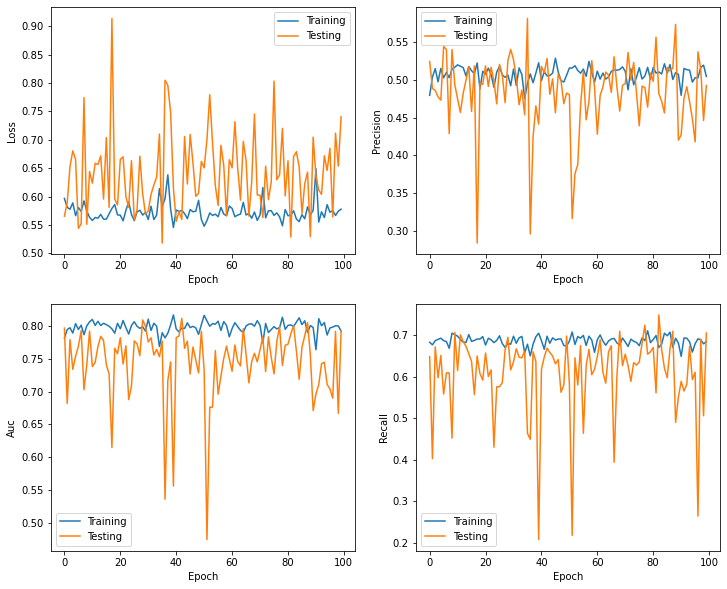

In [19]:
plot_metrics(history)

I am trying differnt perameters, the issue is that for the most part the train scores are good, but the test scores especially in loss go the oposite way. This is an issue of imbalanced data that needs more reading to resolve

#### Confusion matrix

In [20]:
train_predictions_baseline = model.predict(X_train, batch_size=80)
test_predictions_baseline = model.predict(X_test, batch_size=80)

In [49]:
def plot_cm(labels, predictions, p=.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

## This code was found on tensorflow's website

Legitimate Transactions Detected (True Negatives):  117
Legitimate Transactions Incorrectly Detected (False Positives):  2059
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  688
Total Fraudulent Transactions:  688


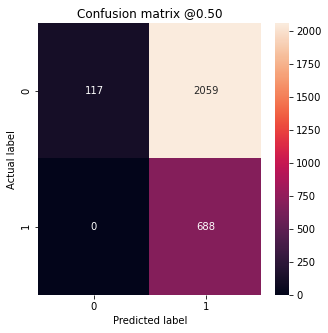

In [50]:
plot_cm(y_test, test_predictions_baseline)

### Conclusion<a id='conc'></a>  
Since this is a work in progress I cannot make a full conclusion on it yet, as it stands now, I need to find a way for my validation set's loss to stop increasing, the confusion matrix here looks good, increasing the true positives, minimizing the false negatives, however at a higher than desirable rate of false positives.